## Install necessary libraries

In [ ]:
!pip install memory_profiler
!pip install opendatasets
!pip install pandas
!pip install tensorflow


# Import required libraries

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import opendatasets as od
import random
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models, losses, metrics
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay




# Download the dataset (replace the URL with your dataset's Kaggle URL)

In [ ]:

od.download("https://www.kaggle.com/datasets/cybersimar08/casia-face-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: muhammedyassir
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/cybersimar08/casia-face-dataset


100%|██████████| 52.2M/52.2M [00:00<00:00, 288MB/s]

In [ ]:
dataset_path = '/content/casia-face-dataset/casia dataset'
if os.path.exists(dataset_path):
    print("Dataset directory loaded successfully.")
else:
    print("Error: Dataset directory not found!")


Dataset directory loaded successfully.


# Organize the dataset into train, validation, and test sets (70%, 15%, 15%)

In [ ]:
# Explore the dataset
subject_folders = os.listdir(dataset_path)
print(f"Total number of subjects: {len(subject_folders)}")
print(f"Example subject folders: {subject_folders[:5]}")

Total number of subjects: 200
Example subject folders: ['000038', '000136', '000039', '000521', '000444']


In [ ]:
# Load and display a sample image
sample_folder = os.path.join(dataset_path, subject_folders[0])
image_files = os.listdir(sample_folder)
sample_image_path = os.path.join(sample_folder, image_files[0])
sample_image = cv2.imread(sample_image_path, cv2.IMREAD_COLOR)
print(f"Sample image shape: {sample_image.shape}")


Sample image shape: (112, 112, 3)


In [ ]:
IMG_SIZE = (64, 64)
images, labels = [], []
label_map = {folder: idx for idx, folder in enumerate(subject_folders)}

for folder in subject_folders:
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is not None:  # Ensure the image is valid
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, IMG_SIZE)
                images.append(img)
                labels.append(label_map[folder])

print(f"Loaded {len(images)} images.")





Loaded 20197 images.


In [ ]:
normalized_images = []
for img in images:
    img = img.astype(np.float32)
    mean_per_channel = np.mean(img, axis=(0, 1))
    img_centered = img - mean_per_channel
    std_per_channel = np.std(img, axis=(0, 1))
    normalized_image = img_centered / (std_per_channel + 1e-7)
    normalized_images.append(normalized_image)
normalized_images = np.array(normalized_images)
print(f"Normalized images shape: {normalized_images.shape}")


Normalized images shape: (20197, 64, 64, 3)


In [ ]:
from sklearn.model_selection import train_test_split

TrainingImages, TempImages, TrainingLabels, TempLabels = train_test_split(
    normalized_images, labels, test_size=0.3, random_state=42, stratify=labels
)
TestingImages, ValidationImages, TestingLabels, ValidationLabels = train_test_split(
    TempImages, TempLabels, test_size=0.5, random_state=42, stratify=TempLabels
)


In [ ]:
np.savez_compressed('./casia_preprocessed_data_100x100.npz',
                    TrainingImages=TrainingImages, TrainingLabels=TrainingLabels,
                    ValidationImages=ValidationImages, ValidationLabels=ValidationLabels,
                    TestingImages=TestingImages, TestingLabels=TestingLabels)
print("Data saved successfully!")

Data saved successfully!


In [ ]:
data = np.load('./casia_preprocessed_data_100x100.npz')
TrainingImages = data['TrainingImages']
TrainingLabels = data['TrainingLabels']
ValidationImages = data['ValidationImages']
ValidationLabels = data['ValidationLabels']
TestingImages = data['TestingImages']
TestingLabels = data['TestingLabels']


In [ ]:
TrainingImages_flat = TrainingImages.reshape(TrainingImages.shape[0], -1).astype('float32')
ValidationImages_flat = ValidationImages.reshape(ValidationImages.shape[0], -1).astype('float32')
TestingImages_flat = TestingImages.reshape(TestingImages.shape[0], -1).astype('float32')


In [ ]:
print(f"Training images shape: {TrainingImages.shape}")
print(f"Validation images shape: {ValidationImages.shape}")
print(f"Testing images shape: {TestingImages.shape}")



Training images shape: (14137, 64, 64, 3)
Validation images shape: (3030, 64, 64, 3)
Testing images shape: (3030, 64, 64, 3)


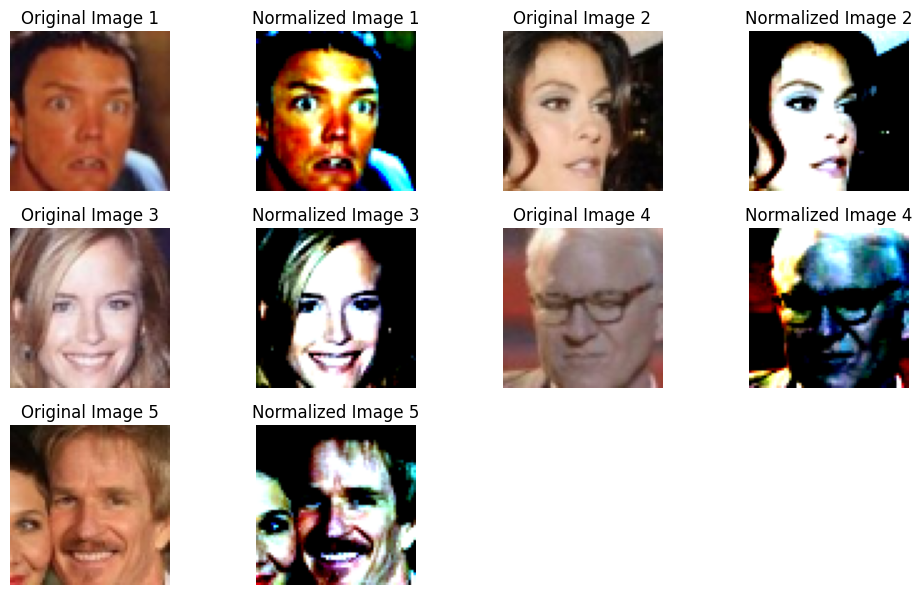

In [ ]:
import matplotlib.pyplot as plt
import random

# Select 10 random indices from the images list
random_indices = random.sample(range(len(images)), 5)

# Create a figure to display the images
plt.figure(figsize=(10, 10))

for i, idx in enumerate(random_indices):
    # Original image (before normalization)
    original_image = images[idx]

    # Normalized image
    normalized_image = normalized_images[idx]

    # Plot original image
    plt.subplot(5, 4, i * 2 + 1)
    plt.imshow(original_image)
    plt.title(f"Original Image {i+1}")
    plt.axis('off')

    # Plot normalized image
    plt.subplot(5, 4, i * 2 + 2)
    plt.imshow(normalized_image)
    plt.title(f"Normalized Image {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


#training CAE

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         524,352 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 618,496 (2.36 MB)

 Trainable params: 618,048 (2.36 MB)

 Non-trainable params: 448 (1.75 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_11CLONE (InputLayer)    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8192)                │         532,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 64, 64, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 773,187 (2.95 MB)

 Trainable params: 773,187 (2.95 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         524,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8192)                │         532,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 64, 64, 32)          │              

 Total params: 1,391,683 (5.31 MB)

 Trainable params: 1,391,235 (5.31 MB)

 Non-trainable params: 448 (1.75 KB)

Training the Convolutional Autoencoder...
Epoch 1/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.3449 - val_loss: 0.1942
Epoch 2/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1841 - val_loss: 0.1711
Epoch 3/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.1686 - val_loss: 0.1647
Epoch 4/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.1649 - val_loss: 0.1637
Epoch 5/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.1608 - val_loss: 0.1604
Epoch 6/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1598 - val_loss: 0.1587
Epoch 7/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.1588 - val_loss: 0.1573
Epoch 8/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.1566 - val_loss: 0.1569
Epoch 9/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1559 - val_loss: 0.1562
Epoch 10/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.1565 - val_loss: 0.1561
Epoch 11/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.1546 - val_loss: 0.1554
Ep

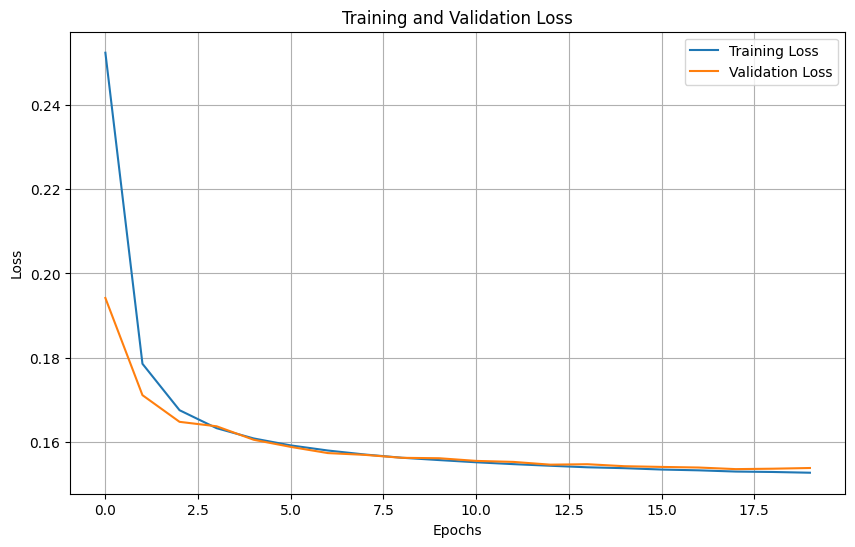

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Constants
BOTTLE_NECK_DIM = 64
BATCH_SIZE = 16
EPOCHS = 20  # Increase epochs for better training
LEARNING_RATE = 0.0001  # Smaller learning rate
DROPOUT_RATE = 0.3  # Dropout to prevent overfitting

# Build Convolutional Autoencoder Model with Linear Activation
def build_convolutional_autoencoder(input_shape):
    # Encoder
    input_layer = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='linear', padding='same')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='linear', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='linear', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    # Bottleneck
    x = tf.keras.layers.Flatten()(x)
    latent_space = tf.keras.layers.Dense(BOTTLE_NECK_DIM, activation='linear')(x)

    # Decoder
    x = tf.keras.layers.Dense(128 * (input_shape[0] // 8) * (input_shape[1] // 8), activation='linear')(latent_space)
    x = tf.keras.layers.Reshape((input_shape[0] // 8, input_shape[1] // 8, 128))(x)

    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), activation='linear', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='linear', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    x = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='linear', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    # Output Layer with Linear Activation
    output_layer = tf.keras.layers.Conv2DTranspose(input_shape[2], (3, 3), activation='linear', padding='same')(x)

    # Models
    encoder = tf.keras.Model(inputs=input_layer, outputs=latent_space)
    decoder = tf.keras.Model(inputs=latent_space, outputs=output_layer)
    autoencoder = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    encoder.summary()
    decoder.summary()
    autoencoder.summary()
    # Compile the model
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse')
    return autoencoder, encoder, decoder

# Train Model
def train_autoencoder(model, train_data, val_data):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,  # Adjust patience to allow more epochs
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        train_data[0], train_data[0],
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(val_data[0], val_data[0]),
        callbacks=[early_stopping]
    )
    return history

# Plot Training History
def plot_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Build and compile the Convolutional Autoencoder model
input_shape = (64, 64, 3)  # Example input shape, adjust to your data
autoencoder, encoder, decoder = build_convolutional_autoencoder(input_shape)

# Train the model
print("Training the Convolutional Autoencoder...")
history = train_autoencoder(autoencoder, (TrainingImages, TrainingLabels), (ValidationImages, ValidationLabels))

# Plot the training and validation loss
plot_history(history)


#cross validation (convolutional autoencoder)

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf

# Constants
K_FOLDS = 5
BATCH_SIZE = 32
EPOCHS = 10
INPUT_SHAPE = (64, 64, 3)  # Adjust according to your data (e.g., 64x64 images with 3 channels)

# Define architectures for Convolutional Autoencoders (CAE)
architectures = [
    {"conv_layers": [32, 64], "bottleneck": 32},  # Architecture 1
    {"conv_layers": [64, 128], "bottleneck": 64},  # Architecture 2
    {"conv_layers": [128, 256], "bottleneck": 128},  # Architecture 3
]

# Build Convolutional Autoencoder Model for Given Architecture
def build_convolutional_autoencoder(input_shape, conv_layers, bottleneck):
    # Encoder
    input_layer = tf.keras.Input(shape=input_shape)
    x = input_layer
    for filters in conv_layers:
        x = tf.keras.layers.Conv2D(filters, (3, 3), activation='linear', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    # Calculate the shape after the convolutional layers
    shape_after_conv = tf.keras.backend.int_shape(x)
    flattened_size = np.prod(shape_after_conv[1:])  # Exclude the batch size dimension

    # Bottleneck (Latent Space)
    x = tf.keras.layers.Flatten()(x)
    latent_space = tf.keras.layers.Dense(bottleneck, activation='linear')(x)

    # Decoder
    x = tf.keras.layers.Dense(flattened_size, activation='linear')(latent_space)
    x = tf.keras.layers.Reshape(shape_after_conv[1:])(x)  # Reshape to the shape after conv layers

    for filters in reversed(conv_layers):
        x = tf.keras.layers.Conv2DTranspose(filters, (3, 3), activation='linear', padding='same')(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)

    # Output Layer with Linear Activation
    output_layer = tf.keras.layers.Conv2DTranspose(input_shape[2], (3, 3), activation='linear', padding='same')(x)

    # Model
    autoencoder = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
    return autoencoder

# Perform K-Fold Cross-Validation
def cross_validate_autoencoder(TrainingImages, architectures, k_folds=K_FOLDS):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    results = []

    for arch_idx, arch in enumerate(architectures):
        print(f"\nEvaluating Architecture {arch_idx + 1}: {arch}")
        fold_losses = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(TrainingImages)):
            print(f"  Fold {fold + 1}/{k_folds}")
            train_data = TrainingImages[train_idx]
            val_data = TrainingImages[val_idx]

            # Build model
            autoencoder = build_convolutional_autoencoder(INPUT_SHAPE, arch["conv_layers"], arch["bottleneck"])

            # Train model
            history = autoencoder.fit(
                train_data, train_data,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                validation_data=(val_data, val_data),
                verbose=0  # Suppress detailed logs
            )

            # Record validation loss
            fold_loss = history.history['val_loss'][-1]
            fold_losses.append(fold_loss)
            print(f"    Fold {fold + 1} Validation Loss: {fold_loss:.4f}")

        # Average loss for this architecture
        avg_loss = np.mean(fold_losses)
        results.append({"architecture": arch, "avg_loss": avg_loss})
        print(f"  Architecture {arch_idx + 1} Average Loss: {avg_loss:.4f}")

    return results

# Perform cross-validation
results = cross_validate_autoencoder(TrainingImages, architectures)

# Print results
print("\nCross-Validation Results:")
for idx, res in enumerate(results):
    print(f"Architecture {idx + 1}: {res['architecture']}, Average Loss: {res['avg_loss']:.4f}")



Evaluating Architecture 1: {'conv_layers': [32, 64], 'bottleneck': 32}
  Fold 1/5
    Fold 1 Validation Loss: 0.2185
  Fold 2/5
    Fold 2 Validation Loss: 0.2186
  Fold 3/5
    Fold 3 Validation Loss: 0.2178
  Fold 4/5
    Fold 4 Validation Loss: 0.2193
  Fold 5/5
    Fold 5 Validation Loss: 0.2183
  Architecture 1 Average Loss: 0.2185

Evaluating Architecture 2: {'conv_layers': [64, 128], 'bottleneck': 64}
  Fold 1/5
    Fold 1 Validation Loss: 0.1587
  Fold 2/5
    Fold 2 Validation Loss: 0.1588
  Fold 3/5
    Fold 3 Validation Loss: 0.1567
  Fold 4/5
    Fold 4 Validation Loss: 0.1621
  Fold 5/5
    Fold 5 Validation Loss: 0.1593
  Architecture 2 Average Loss: 0.1591

Evaluating Architecture 3: {'conv_layers': [128, 256], 'bottleneck': 128}
  Fold 1/5
    Fold 1 Validation Loss: 0.1162
  Fold 2/5
    Fold 2 Validation Loss: 0.1159
  Fold 3/5
    Fold 3 Validation Loss: 0.1173
  Fold 4/5
    Fold 4 Validation Loss: 0.1171
  Fold 5/5
    Fold 5 Validation Loss: 0.1157
  Architecture

#minimum Euclidean distance calssifier

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Constants
BATCH_SIZE = 32
EPOCHS = 10
input_shape = (64, 64, 3)  # Assuming input shape of 64x64 RGB images

# Define the Convolutional Autoencoder (CAE) with Architecture 3
def build_convolutional_autoencoder(input_shape, conv_layers, bottleneck):
    # Encoder
    input_layer = tf.keras.Input(shape=input_shape)
    x = input_layer
    for filters in conv_layers:
        x = tf.keras.layers.Conv2D(filters, (3, 3), activation='linear', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    # Calculate the shape after the convolutional layers
    shape_after_conv = tf.keras.backend.int_shape(x)
    flattened_size = np.prod(shape_after_conv[1:])  # Exclude the batch size dimension

    # Bottleneck (Latent Space)
    x = tf.keras.layers.Flatten()(x)
    latent_space = tf.keras.layers.Dense(bottleneck, activation='linear')(x)

    # Decoder
    x = tf.keras.layers.Dense(flattened_size, activation='linear')(latent_space)
    x = tf.keras.layers.Reshape(shape_after_conv[1:])(x)  # Reshape to the shape after conv layers

    for filters in reversed(conv_layers):
        x = tf.keras.layers.Conv2DTranspose(filters, (3, 3), activation='linear', padding='same')(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)

    # Output Layer with Linear Activation
    output_layer = tf.keras.layers.Conv2DTranspose(input_shape[2], (3, 3), activation='linear', padding='same')(x)

    # Models
    encoder = tf.keras.Model(inputs=input_layer, outputs=latent_space)
    decoder = tf.keras.Model(inputs=latent_space, outputs=output_layer)
    autoencoder = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
    return autoencoder, encoder, decoder

# Step 1: Use Architecture 3 for the Autoencoder
best_architecture = {"conv_layers": [128, 256], "bottleneck": 128}  # Best architecture
autoencoder, encoder, decoder = build_convolutional_autoencoder(input_shape, best_architecture["conv_layers"], 128)

# Step 2: Train the autoencoder (if not already trained)
# Assuming that the model has already been trained, you can skip the training part if the model is pre-trained.
# If you need to train the model, uncomment the following lines:

history = autoencoder.fit(
     TrainingImages, TrainingImages,
     epochs=EPOCHS,
     batch_size=BATCH_SIZE,
     validation_data=(ValidationImages, ValidationImages),
      verbose=1
  )

# Step 3: Extract latent features from the encoder
train_features = encoder.predict(TrainingImages, batch_size=BATCH_SIZE)
test_features = encoder.predict(TestingImages, batch_size=BATCH_SIZE)

# Step 4: Minimum Euclidean Distance Classifier
distances = cdist(test_features, train_features, metric='euclidean')
predicted_labels = [TrainingLabels[np.argmin(dist)] for dist in distances]

# Step 5: Compute recognition accuracy
accuracy = accuracy_score(TestingLabels, predicted_labels)
print(f"Recognition Accuracy using Minimum Euclidean Distance Classifier: {accuracy * 100:.2f}%")



Epoch 1/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - loss: 24.2704 - val_loss: 0.2946
Epoch 2/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - loss: 0.2651 - val_loss: 0.2072
Epoch 3/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - loss: 0.1961 - val_loss: 0.1703
Epoch 4/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 0.1635 - val_loss: 0.1486
Epoch 5/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 0.1451 - val_loss: 0.1346
Epoch 6/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - loss: 0.1322 - val_loss: 0.1257
Epoch 7/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - loss: 0.1246 - val_loss: 0.1188
Epoch 8/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - loss: 0.1187 - val_loss: 0.1159
Epoch 9/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - loss: 0.1158 - val_loss: 0.1160
Epoch 10/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - loss: 0.1143 - val_loss: 0.1142
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Recognition Accuracy using Minimum Euc

# Step 6: Confusion Matrix

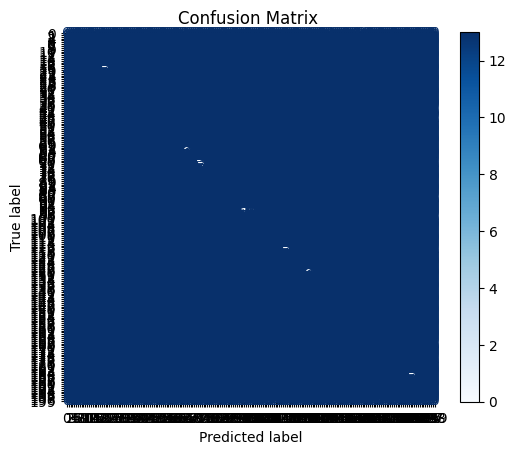

In [ ]:


cm = confusion_matrix(TestingLabels, predicted_labels)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(TestingLabels))
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer format
plt.title('Confusion Matrix ')
plt.show()


In [ ]:
print("Predicted labels:", predicted_labels[:10])  # Print the first 10 predictions
print("True labels:", TestingLabels[:10])  # Print the first 10 true labels


Predicted labels: [33, 110, 97, 86, 194, 128, 115, 188, 99, 125]
True labels: [ 33  70  31 106   9  50  67  20  50  41]


#visualize the images with true and predicted labels

Label Map: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16', 17: '17', 18: '18', 19: '19', 20: '20', 21: '21', 22: '22', 23: '23', 24: '24', 25: '25', 26: '26', 27: '27', 28: '28', 29: '29', 30: '30', 31: '31', 32: '32', 33: '33', 34: '34', 35: '35', 36: '36', 37: '37', 38: '38', 39: '39', 40: '40', 41: '41', 42: '42', 43: '43', 44: '44', 45: '45', 46: '46', 47: '47', 48: '48', 49: '49', 50: '50', 51: '51', 52: '52', 53: '53', 54: '54', 55: '55', 56: '56', 57: '57', 58: '58', 59: '59', 60: '60', 61: '61', 62: '62', 63: '63', 64: '64', 65: '65', 66: '66', 67: '67', 68: '68', 69: '69', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '80', 81: '81', 82: '82', 83: '83', 84: '84', 85: '85', 86: '86', 87: '87', 88: '88', 89: '89', 90: '90', 91: '91', 92: '92', 93: '93', 94: '94', 95: '95', 96: '96', 97: '97', 98: '98', 99: '99', 100: '10

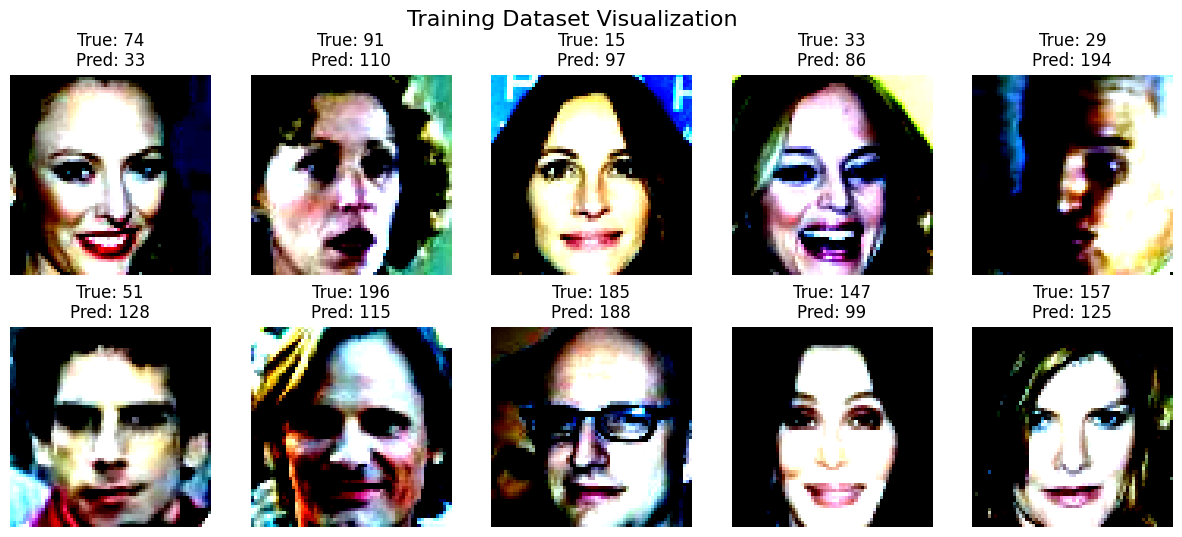

In [ ]:


def visualize_images_with_labels(images, true_labels, predicted_labels, label_map, title, num_images=10):
    plt.figure(figsize=(15, 6))
    for i in range(min(num_images, len(images))):  # Limit to num_images
        plt.subplot(2, 5, i + 1)  # Create a 2x5 grid for image display
        plt.imshow(images[i])  # Display the image
        plt.axis('off')  # Hide axes
        true_label = label_map.get(true_labels[i], 'Unknown')  # Get the true label from the map (with a fallback)
        predicted_label = label_map.get(predicted_labels[i], 'Unknown')  # Get predicted label
        plt.title(f"True: {true_label}\nPred: {predicted_label}")  # Display true and predicted labels
    plt.suptitle(title, fontsize=16)
    plt.show()

# Step 1: Create a label map dynamically from the unique labels in the dataset
unique_labels = np.unique(np.concatenate([TrainingLabels, ValidationLabels, TestingLabels]))  # Combine all datasets
label_map = {label: str(label) for label in unique_labels}  # Mapping labels to string for visualization

# Check if label_map contains all the necessary labels
print("Label Map:", label_map)

# Step 2: Visualize the Training Dataset
visualize_images_with_labels(TrainingImages, TrainingLabels, predicted_labels[:len(TrainingImages)], label_map, title="Training Dataset Visualization", num_images=10)


